# Diabetes Dataset Classification

LOAD DATA

In [1]:
import importlib
import functions
importlib.reload(functions)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import torch 
import torch.nn as nn
import torch.optim as optim
from functions import scaled_tensorize_data, datasets_and_loaders, train_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


diabetes_data = pd.read_csv('DATASET\diabetes_binary_health_indicators_BRFSS2015.csv')

Y = diabetes_data["Diabetes_binary"]
X = diabetes_data.drop("Diabetes_binary", axis=1)

y = diabetes_data["Diabetes_binary"]



In [2]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)

(202944, 21)


In [3]:
pipeline = Pipeline([
        ('median', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('classifier',LogisticRegression())])

pipeline.fit(X_train, Y_train)

print("Accuracy:", pipeline.score(X_test,Y_test ))


Accuracy: 0.8621294544307789


c:\Users\alexd\Github\Intro-ML-Mini-Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Epoch   1/50] LR 1.000e-03 | Train loss 13.1550  Train acc 71.21% | Val loss 13.1537  Val acc 75.61%
[Epoch   5/50] LR 1.000e-03 | Train loss 13.0603  Train acc 80.07% | Val loss 13.1459  Val acc 79.97%
[Epoch  10/50] LR 1.000e-03 | Train loss 13.0310  Train acc 76.06% | Val loss 13.1369  Val acc 75.80%
[Epoch  15/50] LR 1.000e-04 | Train loss 12.9832  Train acc 71.09% | Val loss 13.1293  Val acc 70.88%
[Epoch  20/50] LR 1.000e-04 | Train loss 12.9714  Train acc 71.88% | Val loss 13.1330  Val acc 71.52%
[Epoch  25/50] LR 1.000e-05 | Train loss 12.9675  Train acc 71.82% | Val loss 13.1334  Val acc 71.54%
[Epoch  30/50] LR 1.000e-06 | Train loss 12.9658  Train acc 71.82% | Val loss 13.1343  Val acc 71.58%
[Epoch  35/50] LR 1.000e-07 | Train loss 12.9682  Train acc 71.82% | Val loss 13.1342  Val acc 71.57%
[Epoch  40/50] LR 1.000e-08 | Train loss 12.9687  Train acc 71.82% | Val loss 13.1342  Val acc 71.57%
[Epoch  45/50] LR 1.000e-08 | Train loss 12.9755  Train acc 71.82% | Val loss 13.1

KeyError: 'test_loss'

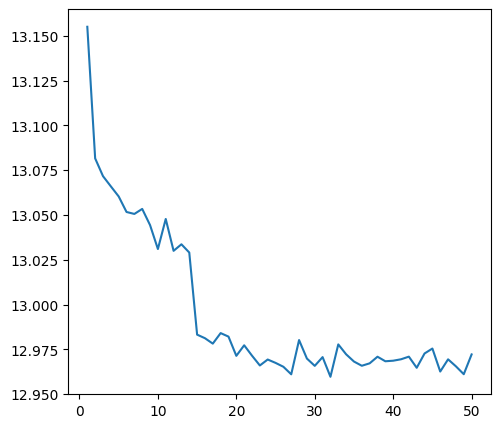

In [ ]:
class MLP_torch(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x
    
input_size = X_train.shape[1]
hidden_size = 64
num_classes = 1

model = MLP_torch(input_size, hidden_size , num_classes)

X_train, Y_train, X_test, Y_test = scaled_tensorize_data(X_train, Y_train, X_test, Y_test)

train_loader, test_loader = datasets_and_loaders(X_train, Y_train, X_test, Y_test, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50
print_every_epochs = 5
path = r"C:\Users\alexd\Github\Neurone_results\best_model.pth"
history = train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs, print_every_epochs, path)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()



In [ ]:
#### Convert in tensor values ####

scaled_tensorize_data(X_train, Y_train, X_test, Y_test)


X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
Y_train_tensor = torch.tensor(Y_train.to_numpy(), dtype = torch.long)
X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
Y_test_tensor = torch.tensor(Y_test.to_numpy(), dtype = torch.long)




In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import math
import os

#### Create datasets ####
train_ds = TensorDataset(X_train_tensor, Y_train_tensor)
test_ds = TensorDataset(X_test_tensor, Y_test_tensor)

#### Create dataloaders ####
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  pin_memory=True, num_workers=0)
val_loader   = DataLoader(test_ds,   batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

##### Define loss function and optimizer ####

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, path):

        # create scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    best_val_loss = math.inf
    save_best_path = path

    for epoch in range(num_epochs):
        model.train()
        train_loss_accum = 0.0
        train_correct = 0
        train_total = 0

        history = { "epoch":[],"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[],"lr":[]}


        for Xb, yb in train_loader:
            
            Xb, yb = Xb.to(device),yb.to(device).long()
            optimizer.zero_grad()
            outputs = model(Xb)
            loss  = criterion( outputs, yb)
            loss.backward()
            optimizer.step()

            batch_size = Xb.size(0)

            train_loss_accum += loss.item()*batch_size

        train_total += batch_size

        # epoch-level train metrics
        train_loss = train_loss_accum / train_total
        train_acc = 100.0 * train_correct / train_total

        model.eval()
        val_loss_accum = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv = Xv.to(device)
                yv = yv.to(device)
                out_v = model(Xv).squeeze()
                l_v = criterion(out_v, yv)
                bs = Xv.size(0)
                val_loss_accum += l_v.item() * bs

                probs_v = torch.sigmoid(out_v)
                preds_v = (probs_v >= 0.5).int()

                _, preds_v = torch.max(out_v, dim=1)  
                val_correct += torch.sum(preds_v == yv).item()
                val_total += bs

        avg_val_loss = val_loss_accum / val_total
        val_acc = 100.0 * val_correct / val_total

        current_lr = optimizer.param_groups[0]["lr"]

        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(avg_val_loss)
        history["test_acc"].append(val_acc)
        history["lr"].append(current_lr)


        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                # ReduceLROnPlateau expects a metric (validation loss)
                scheduler.step(avg_val_loss)
            else:
                # continuous schedulers step each epoch
                scheduler.step()

        # save best model if improved on val loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            if save_best_path:
                os.makedirs(os.path.dirname(save_best_path), exist_ok=True)
                torch.save(model.state_dict(), save_best_path)
        else:
            epochs_no_improve += 1

    print("Training finished.")
    return history





Training finished.


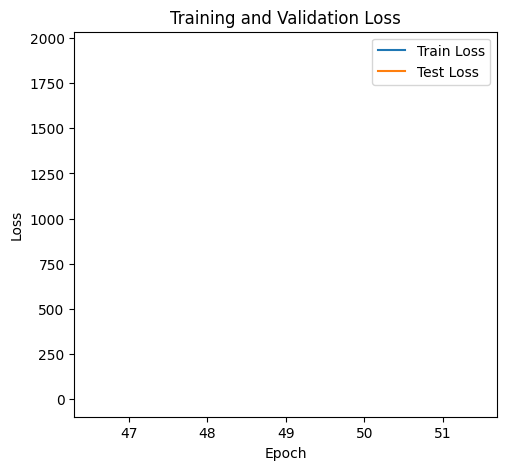

In [ ]:
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs
)
# Plot training/validation loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
